In [1]:
import warnings

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.sparse as scsparse
import scipy.spatial as scspatial
import scipy.stats as scstats
from desmin_reconstruction.plotting.lineplots import line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from jaxtyping import Array, Bool, Float
from tqdm import tqdm


COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00", "actin": "#0000FF"}
LABEL_DICT = {"desmin": "Desmin", "actin": "Actin", "actinin": "α-actinin"}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
out = df.partition_by("probe")

In [65]:
def midpoints(x: Float[np.ndarray, " N"]) -> Float[np.ndarray, " N-1"]:
    return (x[1:] + x[:-1]) / 2


def spearmanr_batched_naive(
    x_batch: Float[np.ndarray, "B N"], y_batch: Float[np.ndarray, "B N"]
) -> Float[np.ndarray, " B"]:
    return np.asarray([scstats.spearmanr(x, y)[0] for x, y in zip(x_batch, y_batch)])


def spearmanr_batched(
    x_batch: Float[np.ndarray, "B N"], y_batch: Float[np.ndarray, "B N"]
) -> Float[np.ndarray, " B"]:
    return scstats.pearsonr(
        scstats.rankdata(x_batch, axis=1), scstats.rankdata(y_batch, axis=1), axis=1
    )[0]


def pearson_r(
    x: Float[Array, " N"], y: Float[Array, " N"], mask: Bool[Array, " N"] | None = None
) -> Float[Array, ""]:
    """
    Computes the Pearson correlation coefficient (r) between data points x, and y.

    If mask is given, r value is computed between x[mask] and y[mask].
    """
    if mask is None:
        mask = jnp.ones_like(x, dtype=jnp.bool)

    def masked_mean(arr: Float[Array, " N"]) -> Float[Array, ""]:
        return jnp.sum(arr * mask) / jnp.sum(mask)

    x_, y_ = x - masked_mean(x), y - masked_mean(y)
    s_xx, s_yy = masked_mean(x_ * x_), masked_mean(y_ * y_)
    s_xy = masked_mean(x_ * y_)
    return s_xy / jnp.sqrt(s_xx * s_yy)


def spearmanr_jax(x: Float[Array, " N"], y: Float[Array, " N"]) -> Float[Array, ""]:
    return pearson_r(
        jax.scipy.stats.rankdata(x),
        jax.scipy.stats.rankdata(y),
    )


def bin_sparse_distance_matrix(
    dist_matrix: scsparse.coo_matrix,
    bins: Float[np.ndarray, " bins"],
    weights: float | np.ndarray = 1.0,
) -> Float[np.ndarray, "rows bins"]:
    bin_idx = np.searchsorted(bins, dist_matrix.data, side="right") - 1
    bincounts = np.zeros(shape=(dist_matrix.shape[0], len(bins) - 1))
    np.add.at(bincounts, (dist_matrix.row, bin_idx), weights)
    return bincounts


def coordinate_based_colocalization(
    points: Float[np.ndarray, "N dim"],
    points_other: Float[np.ndarray, "N_other dim"],
    r_max: float,
    bins: int,
) -> Float[np.ndarray, " N"]:
    dim = points.shape[1]
    if dim != points_other.shape[1]:
        raise ValueError(
            "Coordinates for the two species must have the same number of dimensions"
        )

    tree_self = scspatial.KDTree(points)
    tree_other = scspatial.KDTree(points_other)

    dist_mat_aa = tree_self.sparse_distance_matrix(
        tree_self, max_distance=r_max, output_type="coo_matrix"
    )
    dist_mat_ab = tree_self.sparse_distance_matrix(
        tree_other, max_distance=r_max, output_type="coo_matrix"
    )
    distance_bins: Float[np.ndarray, "bins+1"] = np.linspace(0, r_max, bins + 1)
    dist_weights: Float[np.ndarray, "bins"] = (r_max / midpoints(distance_bins)) ** dim

    counts_aa: Float[np.ndarray, "N bins"] = np.cumsum(
        bin_sparse_distance_matrix(dist_mat_aa, distance_bins), axis=-1
    )
    D_aa = (counts_aa / counts_aa[:, -1:]) * dist_weights

    counts_ab: Float[np.ndarray, "N bins"] = np.cumsum(
        bin_sparse_distance_matrix(dist_mat_ab, distance_bins), axis=-1
    )
    D_ab = (counts_ab / counts_ab[:, -1:]) * dist_weights

    S_a: Float[np.ndarray, " N"] = spearmanr_batched(D_aa, D_ab)

    min_dist_ab: Float[np.ndarray, " N"] = (
        dist_mat_ab.min(axis=1, explicit=True).toarray().squeeze()
    )
    C_a = S_a * np.exp(-min_dist_ab / r_max)
    return C_a

In [4]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(59957, 3)

In [5]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [6]:
idx = 9
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

In [ ]:
tree_desmin = scspatial.KDTree(sq1["desmin"])
tree_actinin = scspatial.KDTree(sq1["actinin"])

r_max = 1.5
bins = 30

r_bins = np.linspace(0, r_max, bins)
r_centers = (r_bins[:-1] + r_bins[1:]) / 2

In [21]:
len(sq1["desmin"])

2464

In [22]:
np.unique(sq1["desmin"], axis=0)

array([[17.00033634,  6.53091029,  0.72891782],
       [17.00044851,  6.52606799,  0.70729455],
       [17.00049499,  6.50870755,  0.77092591],
       ...,
       [20.37368566,  6.54431588,  0.76547046],
       [20.37465027,  6.55129665,  0.81516326],
       [20.38956829,  6.54214711,  0.78750699]], shape=(2459, 3))

In [10]:
dist_mat_aa

<COOrdinate sparse matrix of dtype 'float64'
	with 2604112 stored elements and shape (2464, 2464)>

In [16]:
dist_mat_aa.count_nonzero() + dist_mat_aa.shape[0]

2604082

In [20]:
dist_mat_aa.nnz - dist_mat_aa.count_nonzero()

2494

In [19]:
dist_mat_ab

<COOrdinate sparse matrix of dtype 'float64'
	with 6079154 stored elements and shape (2464, 5887)>

In [18]:
dist_mat_ab.count_nonzero()

6079154

In [6]:
%%timeit
D_aa_all = []
for pt in tree_desmin.data:
    idx_neighbors = tree_desmin.query_ball_point(pt, r_max)
    distances = np.linalg.norm(tree_desmin.data[idx_neighbors] - pt, axis=-1)
    counts, _ = np.histogram(distances, r_bins)
    D_aa = np.cumsum(counts) / np.sum(counts) * (r_max / r_centers) ** 3
    D_aa_all.append(D_aa)
D_aa_all = np.asarray(D_aa_all)

1.05 s ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
dist_mat = tree_desmin.sparse_distance_matrix(
    tree_desmin, r_max, output_type="coo_matrix"
)
bin_idx = np.searchsorted(r_bins, dist_mat.data, side="right") - 1
counts_all = np.zeros_like(bin_idx, shape=(tree_desmin.data.shape[0], len(r_bins) - 1))
np.add.at(counts_all, (dist_mat.row, bin_idx), 1)
counts_all = np.cumsum(counts_all, axis=1)
counts_all = counts_all / counts_all[:, -1:]
D_aa = counts_all * (r_max / r_centers) ** 3

In [17]:
dist_mat = tree_desmin.sparse_distance_matrix(
    tree_actinin, r_max, output_type="coo_matrix"
)
bin_idx = np.searchsorted(r_bins, dist_mat.data, side="right") - 1
counts_all = np.zeros_like(bin_idx, shape=(tree_desmin.data.shape[0], len(r_bins) - 1))
np.add.at(counts_all, (dist_mat.row, bin_idx), 1)
counts_all = np.cumsum(counts_all, axis=1)
counts_all = counts_all / counts_all[:, -1:]
D_ab = counts_all * (r_max / r_centers) ** 3

In [38]:
%%timeit
spearmanr_batched(D_aa, D_ab)


11.8 ms ± 73.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
D_ab.shape

(2464, 30)

In [30]:
%%timeit
scstats.pearsonr(scstats.rankdata(D_aa, axis=1), scstats.rankdata(D_ab, axis=1), axis=1)

11.8 ms ± 70.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
spearmanr_batched(D_aa, D_ab)

PearsonRResult(statistic=array([-0.62168224, -0.48286243,  0.04031183, ...,  0.61986873,
        0.61764379, -0.89166739], shape=(2464,)), pvalue=array([2.45340744e-04, 6.87775964e-03, 8.32496588e-01, ...,
       2.58900346e-04, 2.76439460e-04, 3.82892746e-11], shape=(2464,)))

In [59]:
%%timeit
D_aa_jax = jnp.asarray(D_aa)
D_ab_jax = jnp.asarray(D_ab)
spearmanr_batched_jax = jax.jit(jax.vmap(spearmanr_jax))
spearmanr_batched_jax(D_aa_jax, D_ab_jax).block_until_ready()

941 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
scstats.rankdata(D_ab, axis=1)

array([[ 4. ,  4. ,  4. , ..., 23. , 20. , 18. ],
       [ 3.5,  3.5,  3.5, ..., 21. , 16. , 15. ],
       [ 2.5,  2.5,  2.5, ...,  8. ,  7. ,  6. ],
       ...,
       [ 1.5,  1.5, 30. , ...,  5. ,  7. ,  3. ],
       [ 1.5,  1.5, 29. , ...,  5. ,  6. ,  4. ],
       [ 4. ,  4. ,  4. , ..., 25. , 24. , 23. ]], shape=(2464, 30))

In [19]:
dist_mat.shape

(2464, 5887)

In [22]:
dist_mat

<COOrdinate sparse matrix of dtype 'float64'
	with 6079154 stored elements and shape (2464, 5887)>

In [ ]:
dist_mat.min(axis=1, explicit=True).toarray().squeeze()

array([0.36299996, 0.34053773, 0.22644597, ..., 0.10882858, 0.11782021,
       0.36814175], shape=(2464,))

In [41]:
D_aa_all

array([[6.65911263e+02, 4.93267602e+01, 6.12638362e+01, ...,
        1.29937614e+00, 1.17072303e+00, 1.05356034e+00],
       [2.33068942e+03, 3.32955631e+02, 2.23746184e+02, ...,
        1.30832193e+00, 1.17272427e+00, 1.05356034e+00],
       [1.45969077e+03, 5.22605339e+02, 1.92030431e+02, ...,
        1.29094903e+00, 1.17174943e+00, 1.05356034e+00],
       ...,
       [1.08986267e+04, 7.18698961e+02, 1.78631150e+02, ...,
        1.11415317e+00, 9.96975399e-01, 1.05356034e+00],
       [8.12966667e+03, 6.34458113e+02, 1.83498190e+02, ...,
        1.21694707e+00, 1.08895825e+00, 1.05356034e+00],
       [1.01337240e+04, 8.06664599e+02, 1.99649488e+02, ...,
        1.19474159e+00, 1.13726981e+00, 1.05356034e+00]], shape=(2464, 29))

In [10]:
D_aa_alternative.shape

(2464, 29)

In [16]:
%%timeit
scstats.spearmanr(D_aa_alternative[0], D_aa_alternative[0])

532 μs ± 1.79 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [48]:
np.all(np.isclose(D_aa_all, D_aa_alternative))

np.True_

In [16]:
len(r_bins)

30

In [75]:
corr_scores = coordinate_based_colocalization_naive(
    sq1["desmin"], sq1["actinin"], r_max=1.5, bins=30
)
print(corr_scores)


100%|██████████| 1840/1840 [00:03<00:00, 596.38it/s]

[ 0.18585609  0.26048238  0.26236138 ... -0.34046167 -0.40377743
 -0.45649428]


In [76]:
corr_scores2 = coordinate_based_colocalization(
    sq1["desmin"], sq1["actinin"], r_max=1.5, bins=30
)
print(corr_scores2)

[ 0.18585609  0.26048238  0.26236138 ... -0.34046167 -0.40377743
 -0.45649428]


In [63]:
corr_scores2

array([-0.4880555 , -0.38479342,  0.03466328, ...,  0.57648847,
        0.57098623, -0.69761359], shape=(2464,))

In [15]:
def coordinate_based_colocalization_naive(
    points: Float[np.ndarray, "N dim"],
    points_other: Float[np.ndarray, "N_other dim"],
    r_max: float,
    bins: int,
) -> Float[np.ndarray, " N"]:
    dim = points.shape[1]
    if dim != points_other.shape[1]:
        raise ValueError(
            "Coordinates for the two species must have the same number of dimensions"
        )
    tree_self = scspatial.KDTree(points)
    tree_other = scspatial.KDTree(points_other)

    r_bins = np.linspace(0, r_max, bins + 1)
    distance_weights = (r_max / midpoints(r_bins)) ** dim

    corr_scores = []
    for pt in tqdm(tree_self.data):
        idx_neighbors = tree_self.query_ball_point(pt, r_max)
        distances = np.linalg.norm(tree_self.data[idx_neighbors] - pt, axis=-1)
        counts = np.cumsum(np.histogram(distances, r_bins)[0])
        D_aa = (counts / counts[-1]) * distance_weights

        idx_neighbors = tree_other.query_ball_point(pt, r_max)
        distances_b = np.linalg.norm(tree_other.data[idx_neighbors] - pt, axis=-1)
        counts = np.cumsum(np.histogram(distances_b, r_bins)[0])
        D_ab = (counts / counts[-1]) * distance_weights

        S_a = scstats.spearmanr(D_aa, D_ab)[0]
        C_a = S_a * np.exp(-np.min(distances_b) / r_max)
        corr_scores.append(C_a)
    corr_scores = np.asarray(corr_scores)
    return corr_scores

In [16]:
corr_scores_all_actinin = []

for bbox in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}
    corr_scores_all_actinin.append(
        coordinate_based_colocalization(
            sq1["desmin"], sq1["actinin"], r_max=1.5, bins=30
        )
    )

100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


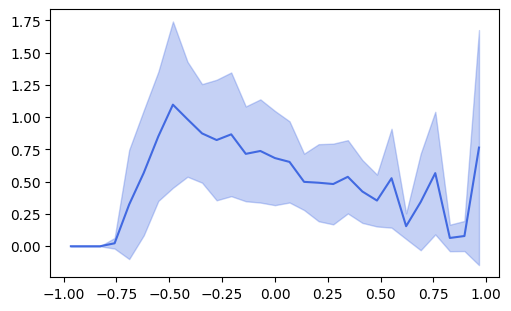

In [18]:
score_bins = np.linspace(-1, 1, 30)
scores_hist_actinin = np.asarray(
    [np.histogram(c, score_bins, density=True)[0] for c in corr_scores_all_actinin]
)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(scores_hist_actinin, axis=0),
    np.std(scores_hist_actinin, axis=0),
)

100%|██████████| 25/25 [02:38<00:00,  6.33s/it]


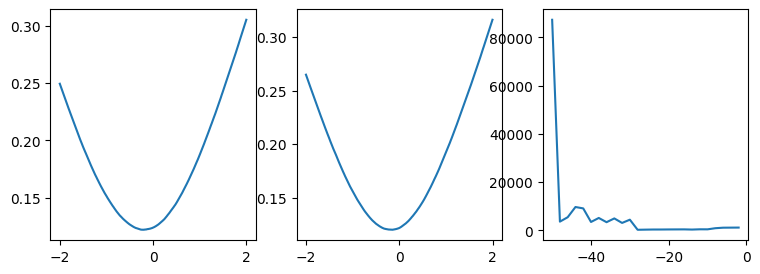

In [ ]:
df = pl.read_csv("../data/results/actin_desmin_600nm_filtered.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("actin", "desmin"))
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-50, 0.0, 2.0),
        min_cluster_size=200,
        min_samples=1,
        clustering_species="actin",
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

points_final = {k: transform_fn(v) for k, v in points.items()}

x0s = (3, 7, 7, 11, 11, 11, 15, 15, 15, 19)
y0s = (-2, -1.5, -5.5, -1, -5, -9, 0.5, -3.5, -7.5, -2)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [7]:
idx = 6
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}

In [8]:
corr_scores_all_actin = []

for bbox in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}
    corr_scores_all_actin.append(
        coordinate_based_colocalization_naive(
            sq1["desmin"], sq1["actin"], r_max=1.5, bins=30
        )
    )

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


In [10]:
score_bins = np.linspace(-1, 1, 30)
scores_hist = np.asarray(
    [np.histogram(c, score_bins, density=True)[0] for c in corr_scores_all_actin]
)

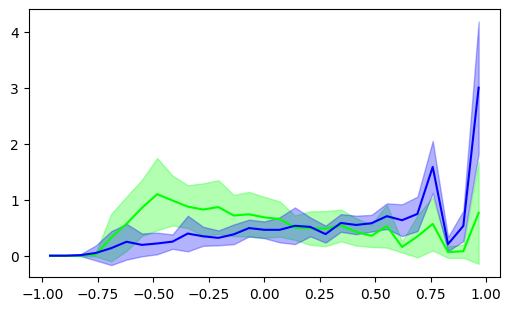

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(scores_hist_actinin, axis=0),
    np.std(scores_hist_actinin, axis=0),
    color=COLOR_DICT["actinin"],
)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(scores_hist, axis=0),
    np.std(scores_hist, axis=0),
    color=COLOR_DICT["actin"],
)

In [33]:
def powspace(start, stop, num, exponent: int):
    powers = np.linspace(start**exponent, stop**exponent, num)
    return powers ** (1 / exponent)

In [34]:
tree_desmin = scspatial.KDTree(sq1["desmin"])
tree_actinin = scspatial.KDTree(sq1["actinin"])

r_max = 1.5
bins = 30

r_bins = np.linspace(0, r_max, bins)
r_centers = (r_bins[:-1] + r_bins[1:]) / 2

dist_mat_aa = tree_desmin.sparse_distance_matrix(
    tree_desmin, r_max, output_type="coo_matrix"
)
dist_mat_ab = tree_desmin.sparse_distance_matrix(
    tree_actinin, r_max, output_type="coo_matrix"
)


def remove_diagonal(coo_mat: scsparse.coo_matrix) -> scsparse.coo_matrix:
    """Remove the diagonal elements from a given COO sparse matrix.

    Unlike coo_mat.setdiag(0) followed by coo_mat.eliminate_zeros(), this method
    does not remove nondiagonal explicit zeros."""
    nondiag_inds = np.logical_not(coo_mat.row == coo_mat.col)
    return scsparse.coo_matrix(
        (
            coo_mat.data[nondiag_inds],
            (coo_mat.row[nondiag_inds], coo_mat.col[nondiag_inds]),
        )
    )


In [ ]:
distances = powspace(0, r_max, bins + 1, sq1["desmin"].shape[1])
dist_mat_aa_mod = remove_diagonal(dist_mat_aa)
x_i = tree_desmin.data[dist_mat_aa_mod.row]
x_j = tree_desmin.data[dist_mat_aa_mod.col]

sides = np.asarray([4.0, 4.0, 1.0])
vol = np.prod(sides)
vol_intersection = np.prod(sides - np.abs(x_i - x_j), axis=1)
weights = vol_intersection / vol

In [92]:
from desmin_reconstruction.utils.math import n_sphere_volume


out = bin_sparse_distance_matrix(dist_mat_aa_mod, distances, weights)
G_aa = (
    (vol / (sq1["desmin"].shape[0] - 1))
    * out
    / (n_sphere_volume(sq1["desmin"].shape[1], distances[1]))
)

In [94]:
G_aa.shape

(2464, 30)

In [96]:
xa_i = tree_desmin.data[dist_mat_ab.row]
xb_j = tree_actinin.data[dist_mat_ab.col]

sides = np.asarray([4.0, 4.0, 1.0])
vol = np.prod(sides)
vol_intersection = np.prod(sides - np.abs(xa_i - xb_j), axis=1)
weights = vol_intersection / vol

out = bin_sparse_distance_matrix(dist_mat_ab, distances, weights)
G_ab = (
    (vol / (sq1["desmin"].shape[0] - 1))
    * out
    / (n_sphere_volume(sq1["desmin"].shape[1], distances[1]))
)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  21.,
        140., 147., 158., 138., 147., 170., 117.,  87.,  56.,  32.,  95.,
        144., 240., 160., 174., 112.,  76., 249.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <BarContainer object of 29 artists>)

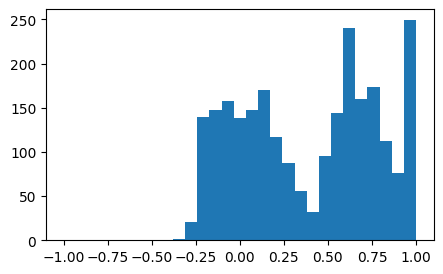

In [99]:
KCBC = jax.vmap(pearson_r)(G_aa, G_ab)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(KCBC, bins=np.linspace(-1, 1, 30))

In [97]:
G_ab.shape

(2464, 30)

In [81]:
out.shape

(2464, 30)

In [82]:
weights

array([0.78563494, 0.97405079, 0.9099188 , ..., 0.95460992, 0.97725966,
       0.95507133], shape=(2601648,))

In [83]:
out

array([[125.33638221,  68.65543034,  30.4858679 , ...,   0.47874752,
          0.        ,   0.        ],
       [143.3546694 ,  82.6949559 ,  21.92983385, ...,   0.        ,
          0.        ,   0.        ],
       [191.63624182, 203.43642144,  53.16250292, ...,   0.51797905,
          0.        ,   0.        ],
       ...,
       [318.91593905,  91.03385379,   0.        , ...,   3.33342202,
         17.86586746,  40.29608775],
       [241.88237373, 154.9312324 ,   0.        , ...,   0.57264575,
          5.52123129,  19.50306688],
       [196.52269232,  56.4168564 ,  41.04207532, ...,   9.34865284,
          6.28909301,   5.10638512]], shape=(2464, 30))

In [101]:
def coordinate_based_colocalization_liu(
    points: Float[np.ndarray, "N dim"],
    points_other: Float[np.ndarray, "N_other dim"],
    r_max: float,
    bins: int,
    sides: Float[np.ndarray, " dim"],
) -> Float[np.ndarray, " N"]:
    dim = points.shape[1]
    if dim != points_other.shape[1]:
        raise ValueError(
            "Coordinates for the two species must have the same number of dimensions"
        )

    tree_self = scspatial.KDTree(points)
    tree_other = scspatial.KDTree(points_other)

    dist_mat_aa = tree_self.sparse_distance_matrix(
        tree_self, max_distance=r_max, output_type="coo_matrix"
    )
    dist_mat_aa = remove_diagonal(dist_mat_aa)

    dist_mat_ab = tree_self.sparse_distance_matrix(
        tree_other, max_distance=r_max, output_type="coo_matrix"
    )

    distances: Float[np.ndarray, "bins+1"] = powspace(0, r_max, bins + 1, exponent=dim)

    vol = np.prod(sides)

    x_i, x_j = tree_self.data[dist_mat_aa.row], tree_self.data[dist_mat_aa.col]
    vol_intersection = np.prod(sides - np.abs(x_i - x_j), axis=1)
    weights = vol_intersection / vol
    G_aa_ = bin_sparse_distance_matrix(dist_mat_aa, distances, weights)
    G_aa = (vol / (len(points) - 1)) * G_aa_ / n_sphere_volume(dim, distances[1])

    xa_i, xb_j = tree_self.data[dist_mat_ab.row], tree_other.data[dist_mat_ab.col]
    vol_intersection = np.prod(sides - np.abs(xa_i - xb_j), axis=1)
    weights = vol_intersection / vol
    G_ab_ = bin_sparse_distance_matrix(dist_mat_ab, distances, weights)
    G_ab = (vol / len(points_other)) * G_ab_ / n_sphere_volume(dim, distances[1])

    KCBC = jax.vmap(pearson_r)(G_aa, G_ab)

    return KCBC

In [103]:
kcbc_actinin = []

for bbox in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}
    kcbc_actinin.append(
        coordinate_based_colocalization_liu(
            sq1["desmin"],
            sq1["actinin"],
            r_max=1.5,
            bins=30,
            sides=np.asarray([4.0, 4.0, 1.0]),
        )
    )

100%|██████████| 16/16 [00:31<00:00,  1.94s/it]


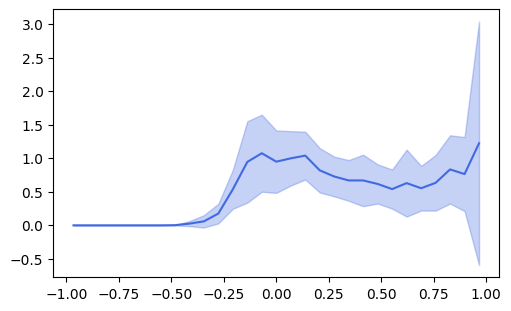

In [105]:
score_bins = np.linspace(-1, 1, 30)
kcbc_hist_actinin = np.asarray(
    [np.histogram(c, score_bins, density=True)[0] for c in kcbc_actinin]
)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(kcbc_hist_actinin, axis=0),
    np.std(kcbc_hist_actinin, axis=0),
)

100%|██████████| 25/25 [02:35<00:00,  6.21s/it]


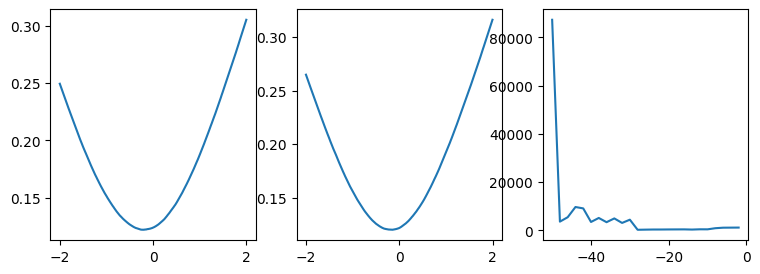

In [106]:
df = pl.read_csv("../data/results/actin_desmin_600nm_filtered.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("actin", "desmin"))
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-50, 0.0, 2.0),
        min_cluster_size=200,
        min_samples=1,
        clustering_species="actin",
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

points_final = {k: transform_fn(v) for k, v in points.items()}

x0s = (3, 7, 7, 11, 11, 11, 15, 15, 15, 19)
y0s = (-2, -1.5, -5.5, -1, -5, -9, 0.5, -3.5, -7.5, -2)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [108]:
kcbc_actin = []

for bbox in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}
    kcbc_actin.append(
        coordinate_based_colocalization_liu(
            sq1["desmin"],
            sq1["actin"],
            r_max=1.5,
            bins=30,
            sides=np.asarray([4.0, 4.0, 1.0]),
        )
    )

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


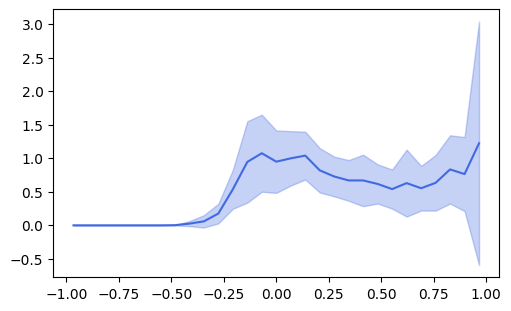

In [109]:
score_bins = np.linspace(-1, 1, 30)
kcbc_hist_actin = np.asarray(
    [np.histogram(c, score_bins, density=True)[0] for c in kcbc_actin]
)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(kcbc_hist_actinin, axis=0),
    np.std(kcbc_hist_actinin, axis=0),
)

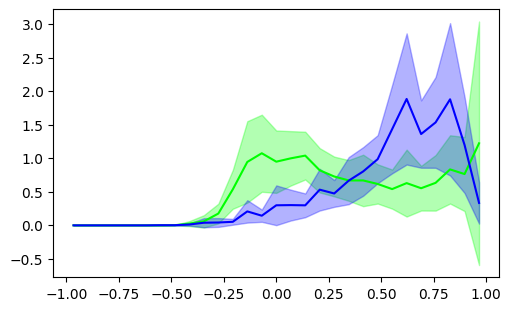

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(kcbc_hist_actinin, axis=0),
    np.std(kcbc_hist_actinin, axis=0),
    color=COLOR_DICT["actinin"],
)
ax = line_and_bandplot(
    ax,
    0.5 * (score_bins[1:] + score_bins[:-1]),
    np.mean(kcbc_hist_actin, axis=0),
    np.std(kcbc_hist_actin, axis=0),
    color=COLOR_DICT["actin"],
)